In [1]:
%matplotlib inline
import numpy as np
from fish.util.distributed import get_cluster
from dask.distributed import Client
from dask.delayed import delayed
from fish.image.zds import ZDS
import dask.array as da
from dask import threaded
from h5py import File
from h5pickle import File as pFile
from functools import partial
from scipy.ndimage.filters import median_filter
from skimage.io import imread
from skimage.transform import downscale_local_mean
from fish.ephys import ephys
import matplotlib.pyplot as plt

import flika as flk
flk.start_flika()

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Starting flika
Starting flika inside IPython


In [25]:
def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

@delayed
def myreg(fixed, moving):
    from fish.image.alignment import estimate_translation    
    return estimate_translation(fixed, moving)

def montage(vol, rgb=False):
    if rgb:
        if vol.ndim == 4:
            return vol.reshape(vol.shape[0] * vol.shape[1], vol.shape[2], vol.shape[3])
        elif vol.ndim == 5:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3], vol.shape[4])
    else:
        if vol.ndim == 4:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3])
        elif vol.ndim == 5:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3], vol.shape[4])

def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 400
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')


In [93]:
ep = ephys.load('/groups/ahrens/ahrenslab/davis/data/ephys/20180406/7dpf_ec43xcy171xcy331_opto_1.10chFlt')
cam = ephys.estimate_onset(ep[2], threshold=3.6, duration=10)
trials = ephys.chop_trials(ep[4])
trials.pop(-1.0);
onsets = {k: ephys.match_cam_time(trials[k][0], cam) + 1 for k in trials.keys()}

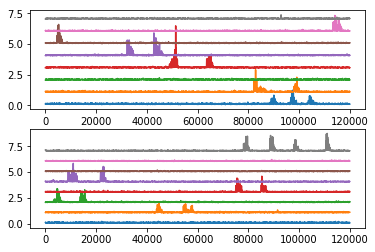

In [121]:
fig, axs = plt.subplots(nrows=2)
tmp = trials[0.0][0][:-1].reshape(-1,1) + np.arange(-6000 * 10, 6000 * 10)
axs[0].plot(500 * ephys.windowed_variance(ep[0])[0][tmp].T + np.arange(tmp.shape[0]));
tmp = trials[1.0][0][:-1].reshape(-1,1) + np.arange(-6000 * 10, 6000 * 10)
axs[1].plot(500 * ephys.windowed_variance(ep[0])[0][tmp].T + np.arange(tmp.shape[0]));

In [58]:
base_dir = '/nrs/ahrens/davis/data/spim/raw/20180406/7dpf_ec43xcy171xcy331_opto_3_20180406_151826/'
dset = ZDS(base_dir)
fs_im = dset.metadata['volume_rate']
chunks=dset.shape[1:]
data = da.stack([da.from_array(File(f,'r')['default'], chunks=chunks) for f in dset.files])
medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data.map_blocks(medfilt)
ref = da.from_array(imread(dset.path.replace('raw','proc') + 'reg/anat_reference.tif'), chunks=data.shape[1:])

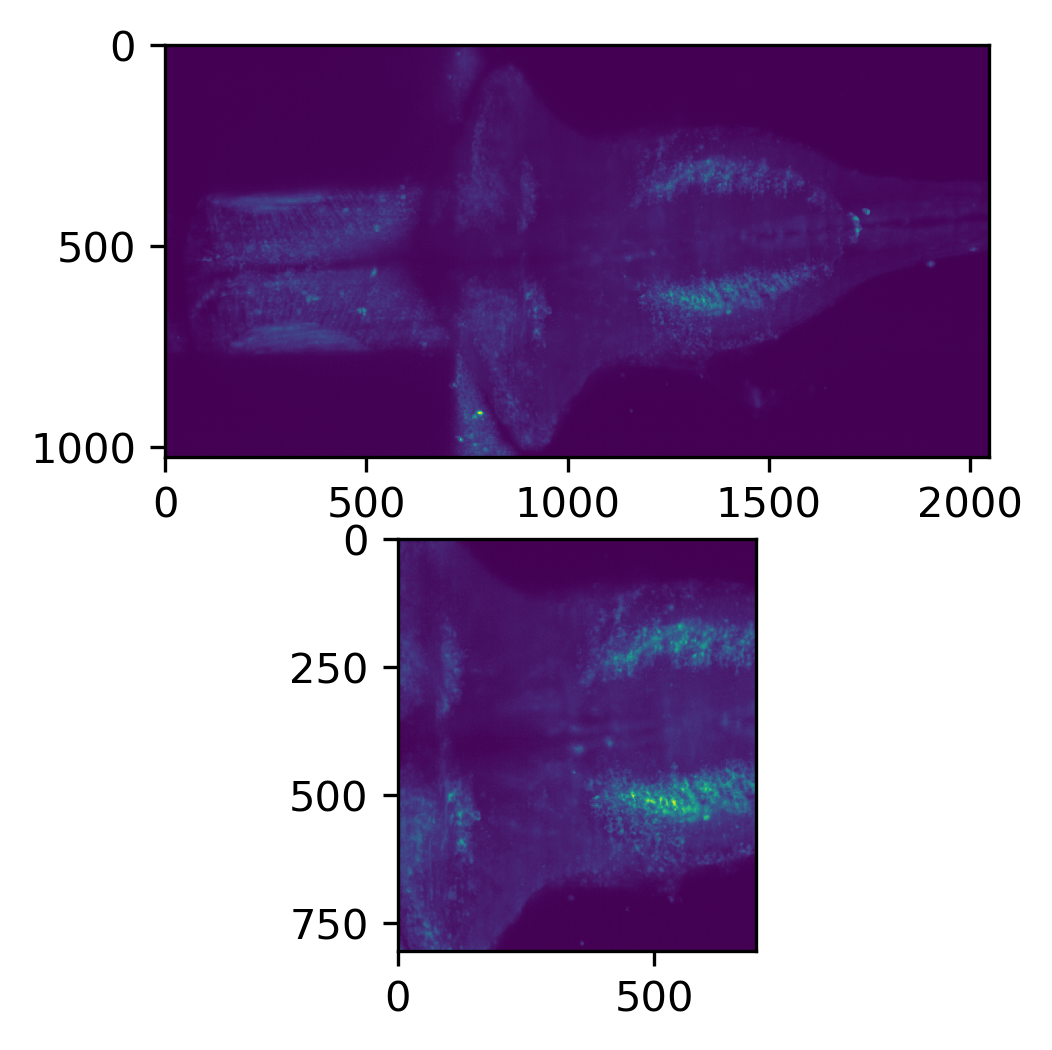

In [81]:
fig, axs = plt.subplots(2,1, dpi=300)
roi = (slice(None), slice(10, None), slice(120,-100), slice(800,1500))
axs[0].imshow(ref.max(0).compute(get=threaded.get))
axs[1].imshow(ref[roi[1:]].max(0).compute(get=threaded.get))

In [82]:
data_roi = data[roi]
shifts = -np.load(dset.path.replace('raw','proc') + 'reg/regparams_affine.npy')[:,:-1,-1]
data_tx = data_roi.map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data_tx.map_blocks(medfilt)

ds_xy = 4
ds_chunks = (1, data_roi.shape[1], data_roi.shape[2]//ds_xy, data_roi.shape[3]//ds_xy)
downscale = partial(downscale_local_mean, factors=(1,1,ds_xy,ds_xy))
data_ds = data_filt.map_blocks(downscale, chunks=ds_chunks)
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 1, 64,64))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

In [83]:
# create objects to manage our interactions with the compute cluster
cluster = get_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.108.26:42122 Dashboard: http://10.36.108.26:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [84]:
%%time
import time

# Request 200 workers from the cluster
cluster.start_workers(200)

# give some time for the workers to arrive
time.sleep(20)

# perform big calculation -- filtering, registration, dff, downsampling
result_dff = client.compute(data_dff, sync=True)

# release the workers
cluster.stop_workers(cluster.workers)
cluster.close()

CPU times: user 3min 51s, sys: 1min 29s, total: 5min 21s
Wall time: 4min 28s


In [85]:
result_dff.shape

(1119, 31, 201, 175)

In [86]:
window = np.arange(-int(10 * fs_im), int(10 * fs_im))
trinds = onsets[1.0].reshape(-1,1)[:-1] + window

In [123]:
flk.window.Window(result_dff[trinds][1].min(1))

In [43]:
result_dff.shape

(3359, 31, 156, 75)

In [56]:
tmp = result_dff[:,:,:,10:-10][trinds].mean(0).max(-1)
flk.window.Window(resize(tmp, (tmp.shape[0], 3 * tmp.shape[1],tmp.shape[2]), preserve_range=True).transpose(0,-2,-1))

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
